In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random
import os

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# drive
from google.colab import drive

# Input dataset

In [4]:
# mount drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
def walk_through_dir(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            print(os.path.join(root, file))

# Now you can call the function
dataset = r'/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3'
walk_through_dir(dataset)

/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/Kura-kura Rote(1)/Chelodina_mccordi_-_Karlsruhe_Zoo_01.jpg
/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/Kura-kura Rote(1)/Chelodina-mccordi-03000042117_01.jpg
/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/Kura-kura Rote(1)/Chelodina-mccordi-03000047704_01.jpg
/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/Kura-kura Rote(1)/1-Figure1-1.png
/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/Kura-kura Rote(1)/kura-kura-leher-ular.jpg
/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/Kura-kura Rote(1)/2711492021-shutterstock_1778933393.jpg
/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/Kura-kura Rote(1)/kura-kura-rote-chelodina-mccordi.jpg
/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/Kura-kura Rote(1)/130679.jpg
/content/gdrive/MyDrive/Capstone Project/Machine learning/Dataset 3/K

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df.head()

,Filepath,Label
0,/content/gdrive/MyDrive/Capstone Project/Machi...,Tuntong Laut(1)
1,/content/gdrive/MyDrive/Capstone Project/Machi...,Tuntong Laut(1)
2,/content/gdrive/MyDrive/Capstone Project/Machi...,Kura-kura Rote(1)
3,/content/gdrive/MyDrive/Capstone Project/Machi...,Kura-kura Rote(1)
4,/content/gdrive/MyDrive/Capstone Project/Machi...,Kura-kura Rote(1)


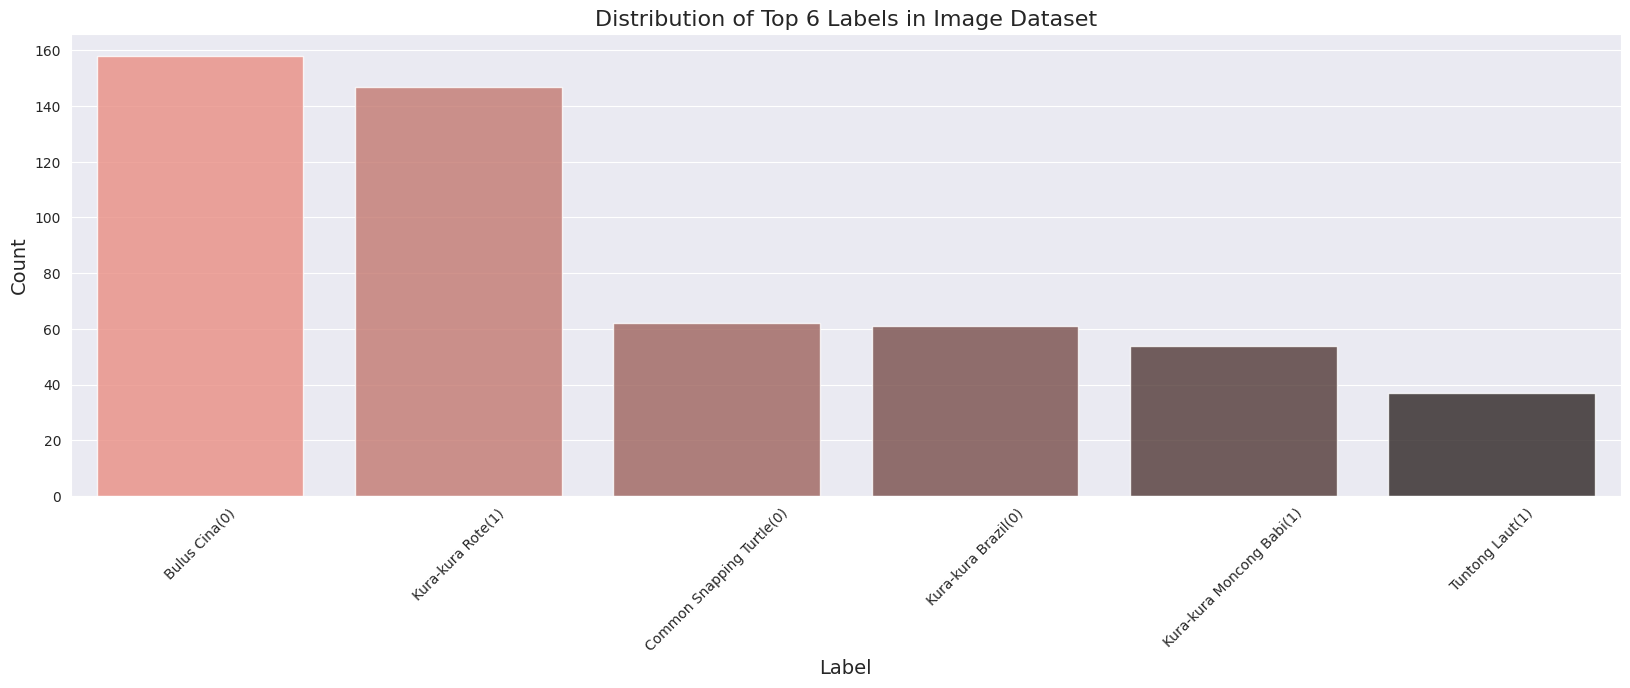

In [8]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 6 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

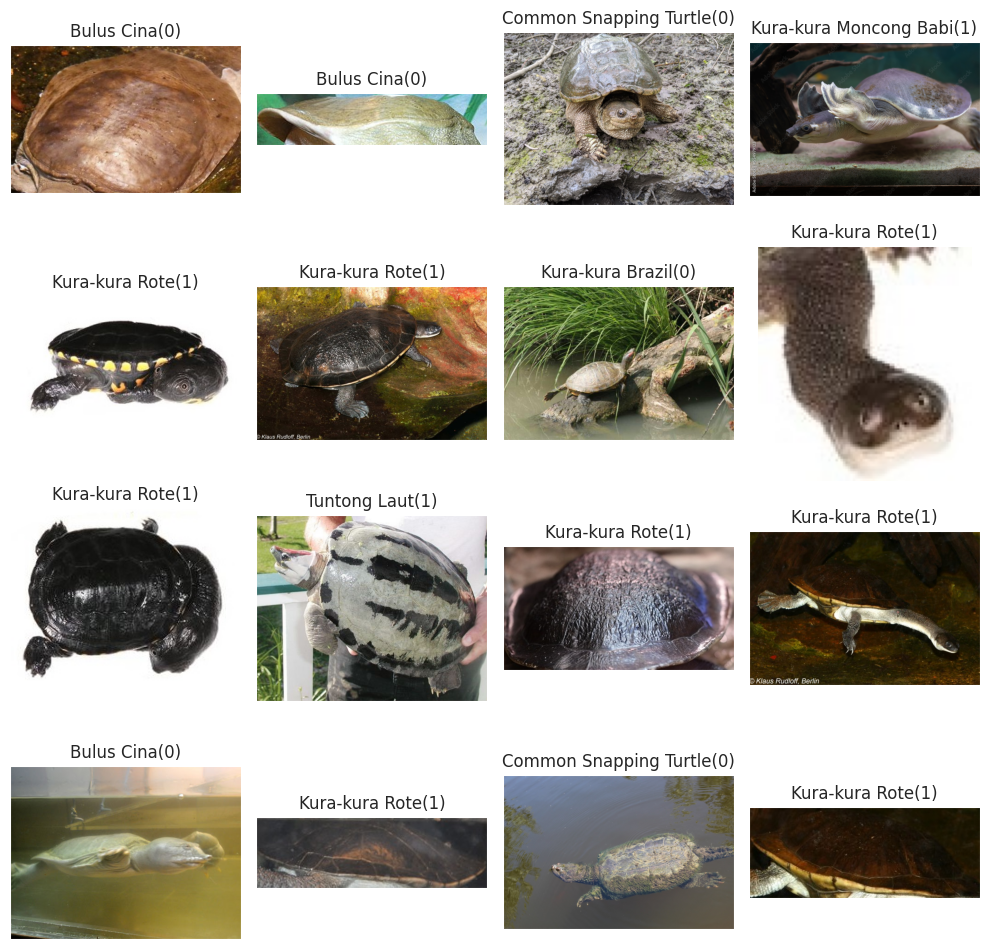

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

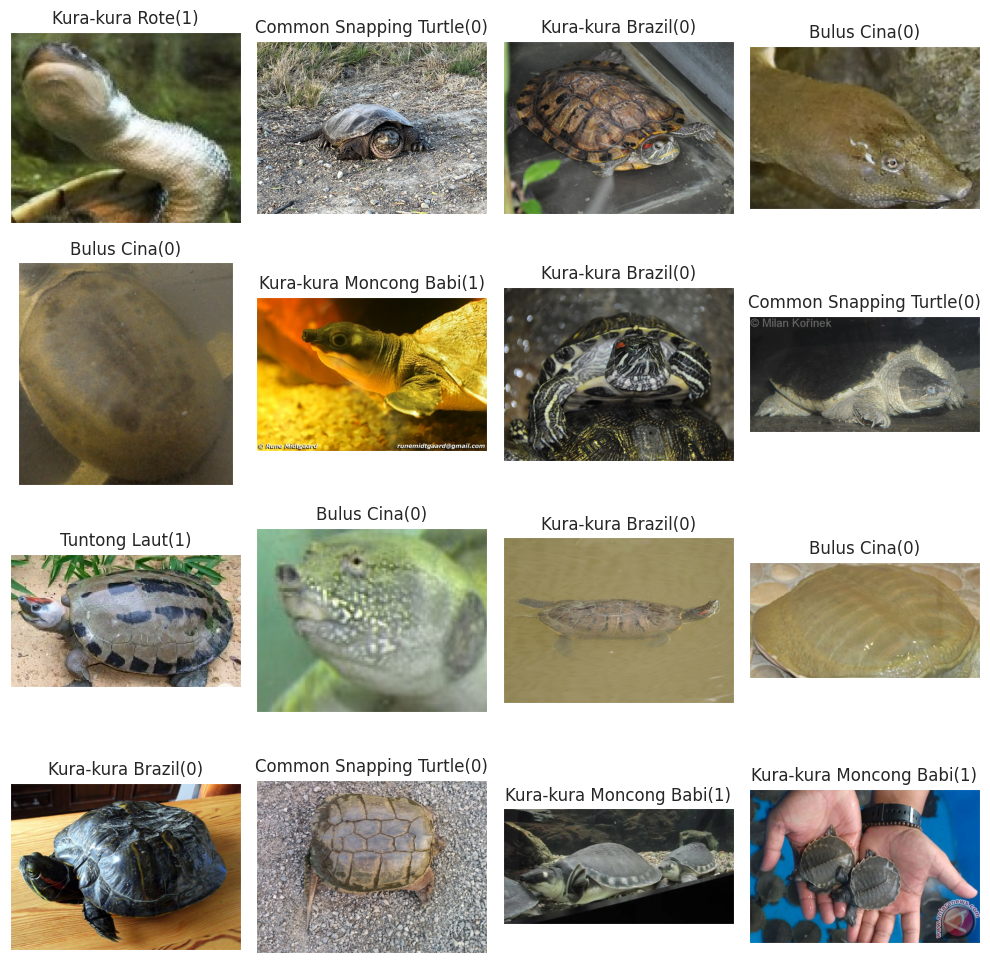

In [10]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Processing

In [11]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [12]:
'''# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)'''

'# Separate in train and test data\ntrain_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)'

In [13]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Split the data into train and test data with oversampling
X_train, X_test, y_train, y_test = train_test_split(
    image_df['Filepath'],
    image_df['Label'],
    test_size=0.2,
    random_state=42,
    stratify=image_df['Label']  # Ensure stratified split based on class labels
)

# Apply oversampling to the training set
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(
    X_train.values.reshape(-1, 1),  # Reshape to maintain compatibility with the API
    y_train.values
)

# Convert oversampled data back to DataFrame
oversampled_df = pd.DataFrame({
    'Filepath': X_train_resampled.flatten(),
    'Label': y_train_resampled
})

# Separate oversampled data into train and validation data
train_df, test_df = train_test_split(
    oversampled_df,
    test_size=0.2,
    random_state=42,
    stratify=oversampled_df['Label']  # Ensure stratified split based on class labels
)


In [14]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [15]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 484 validated image filenames belonging to 6 classes.
Found 120 validated image filenames belonging to 6 classes.
Found 152 validated image filenames belonging to 6 classes.


In [16]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
  # tambahan
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='nearest'),
  layers.GaussianNoise(0.1)
])


# Training the model

In [17]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [18]:
# Create checkpoint callback
checkpoint_path = "turtle_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [19]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(6, activation='softmax')(x)

# Modify the model to utilize GPU
with tf.device('/device:GPU:0'):
    model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=150,
)

Epoch 1/150
16/16 [==============================] - 91s 5s/step - loss: 5.0903 - accuracy: 0.1612 - val_loss: 2.0792 - val_accuracy: 0.2250
Epoch 2/150
16/16 [==============================] - 4s 251ms/step - loss: 3.2371 - accuracy: 0.2397 - val_loss: 1.6852 - val_accuracy: 0.2917
Epoch 3/150
16/16 [==============================] - 4s 262ms/step - loss: 2.5935 - accuracy: 0.2314 - val_loss: 1.4729 - val_accuracy: 0.4083
Epoch 4/150
16/16 [==============================] - 4s 243ms/step - loss: 2.1606 - accuracy: 0.2521 - val_loss: 1.3923 - val_accuracy: 0.4500
Epoch 5/150
16/16 [==============================] - 4s 273ms/step - loss: 1.9890 - accuracy: 0.2686 - val_loss: 1.3587 - val_accuracy: 0.5000
Epoch 6/150
16/16 [==============================] - 4s 268ms/step - loss: 1.8081 - accuracy: 0.3182 - val_loss: 1.3215 - val_accuracy: 0.5083
Epoch 7/150
16/16 [==============================] - 4s 232ms/step - loss: 1.6933 - accuracy: 0.3781 - val_loss: 1.2890 - val_accuracy: 0.5833
E

# model evaluation

In [20]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.17227
Test Accuracy: 92.11%


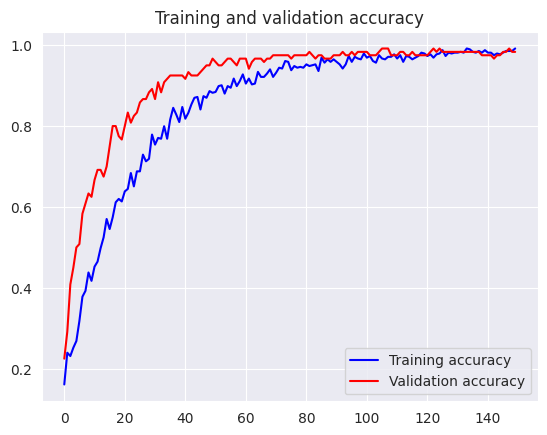

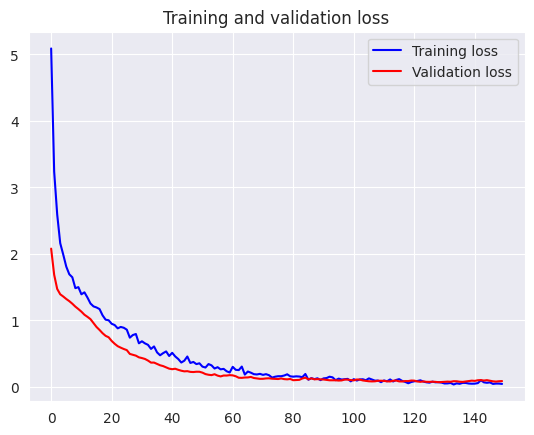

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# prediction

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

5/5 [==============================] - 3s 241ms/step
The first 5 predictions: ['Bulus Cina(0)', 'Kura-kura Moncong Babi(1)', 'Kura-kura Moncong Babi(1)', 'Kura-kura Brazil(0)', 'Kura-kura Moncong Babi(1)']


In [23]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

# plotting the classification

In [24]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                           precision    recall  f1-score   support

            Bulus Cina(0)       0.88      0.92      0.90        25
Common Snapping Turtle(0)       0.81      1.00      0.89        25
      Kura-kura Brazil(0)       0.96      0.92      0.94        25
Kura-kura Moncong Babi(1)       0.96      1.00      0.98        26
        Kura-kura Rote(1)       0.95      0.81      0.88        26
          Tuntong Laut(1)       1.00      0.88      0.94        25

                 accuracy                           0.92       152
                macro avg       0.93      0.92      0.92       152
             weighted avg       0.93      0.92      0.92       152



In [25]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                           precision    recall  f1-score   support

            Bulus Cina(0)       0.88      0.92      0.90        25
Common Snapping Turtle(0)       0.81      1.00      0.89        25
      Kura-kura Brazil(0)       0.96      0.92      0.94        25
Kura-kura Moncong Babi(1)       0.96      1.00      0.98        26
        Kura-kura Rote(1)       0.95      0.81      0.88        26
          Tuntong Laut(1)       1.00      0.88      0.94        25

                 accuracy                           0.92       152
                macro avg       0.93      0.92      0.92       152
             weighted avg       0.93      0.92      0.92       152



# Save the model

In [26]:
model.save('model_6_class.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# save the tf lite

In [29]:
# Load the trained model
model_tflite = tf.keras.models.load_model('model_6_class.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_tflite)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model_6_class.tflite', 'wb') as f:
    f.write(tflite_model)